initializing ocelot...
Applied misalignments to 214 quadrupoles.
Missing in Excel: 14

First misaligned elements (after detrending):
PDA1M         dx=1.058082e-02  dy=-4.178880e-03
PFA1M         dx=1.060222e-02  dy=-4.142210e-03
PDA21         dx=1.044596e-02  dy=-3.706340e-03
PFA21         dx=1.048444e-02  dy=-3.542796e-03
QDA23         dx=1.006542e-02  dy=-2.925109e-03
QFA23         dx=1.011028e-02  dy=-2.873703e-03
QDA23         dx=1.006542e-02  dy=-2.925109e-03
QDA24         dx=9.808566e-03  dy=-3.075973e-03
QFA24         dx=9.883371e-03  dy=-3.039989e-03
QDA24         dx=9.808566e-03  dy=-3.075973e-03


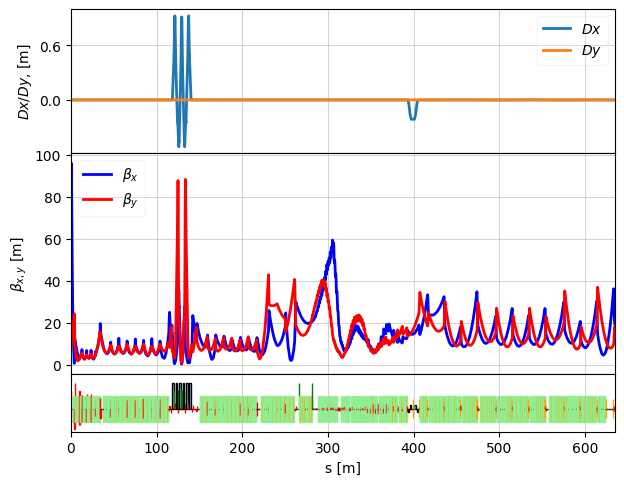


Tracking WITHOUT wakefields...
z = 634.9428243991842 / 634.9428243991842. Applied: Tracking time: 40.62s


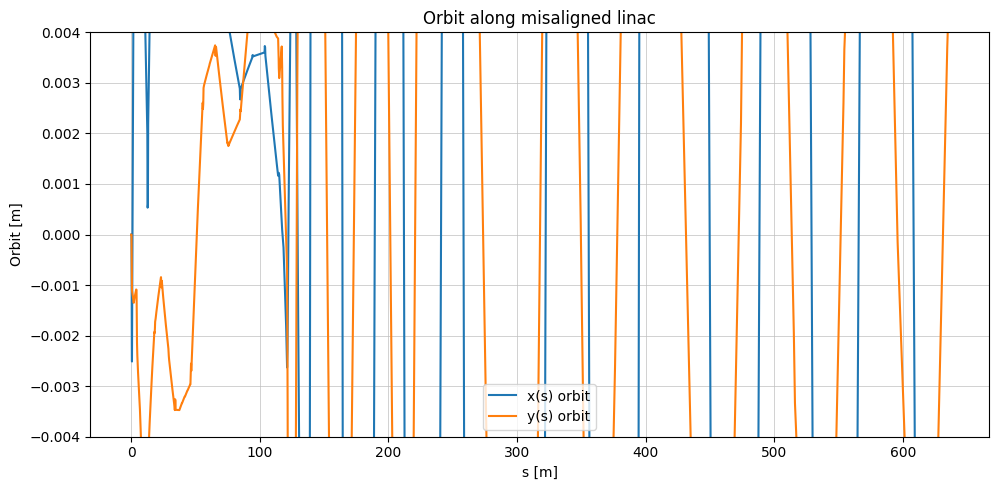

In [1]:
from ocelot import *
from ocelot.cpbd.elements import *
from ocelot.gui.accelerator import *
from ocelot.cpbd.track import track_debug
import matplotlib.pyplot as plt
import time
import numpy as np
import openpyxl



from rfglinacbte1 import *

# ---------------------------------------------------------
# LOAD LATTICE
# ---------------------------------------------------------

lat = MagneticLattice(linac)

# ---------------------------------------------------------
# APPLY MISALIGNMENTS FROM EXCEL (WITH DETRENDING)
# ---------------------------------------------------------
excel_file = "injector_lattice_20230303-2.xlsx"
sheet_name = "lattice"

wb = openpyxl.load_workbook(excel_file, data_only=True)
ws = wb[sheet_name]

# Row 12 contains headers
headers = [c.value for c in ws[12]]
col = {h: i for i, h in enumerate(headers)}

name_col = "element_name"
dx_col = "Δx [mm]"
dz_col = "Δz [mm]"
s_col  = "s [m]"

raw_names = []
raw_dx = []
raw_dz = []
raw_s = []

# Read Excel data
for row in ws.iter_rows(min_row=13, values_only=True):
    name = row[col[name_col]]
    if not name:
        continue

    raw_names.append(str(name).strip())
    raw_dx.append(float(row[col[dx_col]] or 0.0))
    raw_dz.append(float(row[col[dz_col]] or 0.0))
    raw_s.append(float(row[col[s_col]] or 0.0))

# Convert to numpy arrays
names = np.array(raw_names, dtype=str)
dx = np.array(raw_dx, dtype=float)
dz = np.array(raw_dz, dtype=float)
s  = np.array(raw_s,  dtype=float)

# ---------------------------------------------------------
# REMOVE LINEAR DRIFT (DETREND)
# ---------------------------------------------------------
px = np.polyfit(s, dx, 1)
pz = np.polyfit(s, dz, 1)

dx_det = dx - np.polyval(px, s)
dz_det = dz - np.polyval(pz, s)

# Convert mm → meters for OCELOT
dx_m = dx_det * 1e-3
dy_m = dz_det * 1e-3   # dz = vertical (→ dy in OCELOT)

# Build lookup dictionary
def normalize(n):
    return str(n).replace("_", "").upper().strip()

misalign = {normalize(n): {"dx": dx_m[i], "dy": dy_m[i]} 
            for i, n in enumerate(names)}

# ---------------------------------------------------------
# APPLY ONLY TO QUADRUPOLES
# ---------------------------------------------------------
applied = []
missing = []

for elem in lat.sequence:
    if not isinstance(elem, Quadrupole):
        continue

    name = getattr(elem, "id", None)
    if not name:
        continue

    norm = normalize(name)

    if norm in misalign:
        elem.dx = misalign[norm]["dx"]
        elem.dy = misalign[norm]["dy"]
        applied.append(name)
    else:
        missing.append(name)

print(f"Applied misalignments to {len(applied)} quadrupoles.")
print(f"Missing in Excel: {len(missing)}")
print()

# ---------------------------------------------------------
# CHECK THE FIRST 10 MISALIGNED ELEMENTS
# ---------------------------------------------------------
print("First misaligned elements (after detrending):")
c = 0
for e in lat.sequence:
    if isinstance(e, Quadrupole):
        dx = getattr(e, "dx", 0.0)
        dy = getattr(e, "dy", 0.0)
        if abs(dx) > 1e-12 or abs(dy) > 1e-12:
            print(f"{e.id:12s}  dx={dx:.6e}  dy={dy:.6e}")
            c += 1
            if c == 10:
                break


# ---------------------------------------------------------
# TWISS INPUT
# ---------------------------------------------------------
AX = -13.25; BX = 48.65; AY = -2.11; BY = 13.45
EMITX = 1.2e-6; EMITY = 1.2e-6
energy = 0.0328   # GeV

tw0 = Twiss()
tw0.alpha_x = AX; tw0.beta_x = BX
tw0.alpha_y = AY; tw0.beta_y = BY
tw0.E = energy
tw0.emit_xn = EMITX
tw0.emit_yn = EMITY
tw0.emit_x = EMITX / energy * 0.511e-3
tw0.emit_y = EMITY / energy * 0.511e-3

tws = twiss(lat, tw0)

# ---------------------------------------------------------
# PLOT OPTICAL FUNCTIONS
# ---------------------------------------------------------
plot_opt_func(lat, tws, top_plot=["Dx","Dy"], legend=False, font_size=10)
plt.show()

# ---------------------------------------------------------
# PARTICLE DISTRIBUTION
# ---------------------------------------------------------
nparticles = 100000
p_array = ParticleArray(n=nparticles)

charge = 2e-9
sigma_tau = 1e-3
sigma_p = 0.001

p_array.E = energy
p_array.rparticles[4] = np.random.randn(nparticles) * sigma_tau
p_array.rparticles[5] = np.random.randn(nparticles) * sigma_p
p_array.q_array = np.ones(nparticles) * charge / nparticles

# Generate transverse (x, x'), (y, y') from Twiss
for i in range(nparticles):
    p_array.rparticles[0][i], p_array.rparticles[1][i] = gauss_from_twiss(tw0.emit_x, tw0.beta_x, tw0.alpha_x)
    p_array.rparticles[2][i], p_array.rparticles[3][i] = gauss_from_twiss(tw0.emit_y, tw0.beta_y, tw0.alpha_y)

# ---------------------------------------------------------
# TRACKING
# ---------------------------------------------------------
navi = Navigator(lat)
navi.unit_step = 0.1

p_no = deepcopy(p_array)

print("\nTracking WITHOUT wakefields...")
start = time.time()
tws_no, p_no = track(lat, p_no, navi)
print(f"Tracking time: {time.time() - start:.2f}s")

# ---------------------------------------------------------
# PLOT ORBIT
# ---------------------------------------------------------
s = [tw.s for tw in tws_no]
x = [tw.x for tw in tws_no]
y = [tw.y for tw in tws_no]

plt.figure(figsize=(10,5))
plt.plot(s, x, label="x(s) orbit")
plt.plot(s, y, label="y(s) orbit")
plt.xlabel("s [m]")
plt.ylabel("Orbit [m]")
plt.title("Orbit along misaligned linac")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.ylim(-0.004, 0.004)
plt.show()


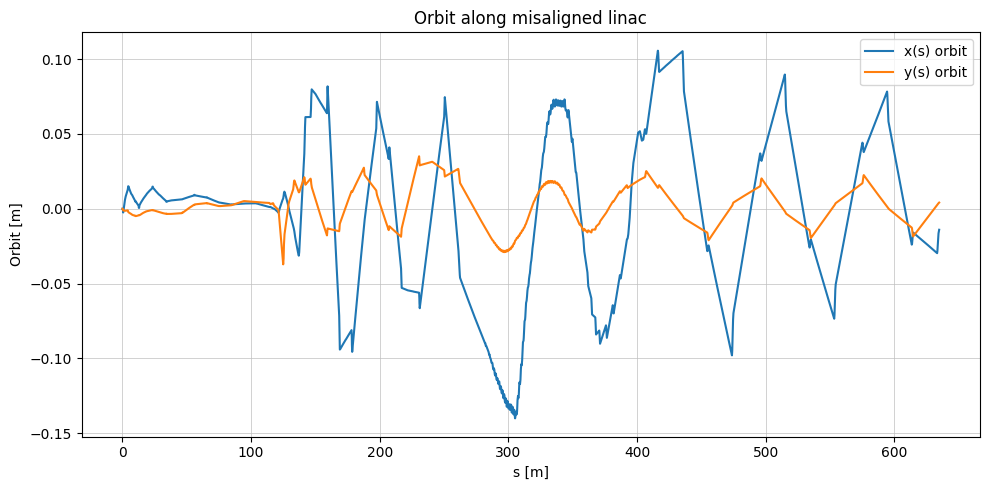

In [2]:
s = [tw.s for tw in tws_no]
x = [tw.x for tw in tws_no]
y = [tw.y for tw in tws_no]

plt.figure(figsize=(10,5))
plt.plot(s, x, label="x(s) orbit")
plt.plot(s, y, label="y(s) orbit")
plt.xlabel("s [m]")
plt.ylabel("Orbit [m]")
plt.title("Orbit along misaligned linac")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
print("Misaligned QUADs:")
for elem in lat.sequence:
    if hasattr(elem, "dx") and (abs(elem.dx) > 1e-12 or abs(elem.dy) > 1e-12):
        print(f"{elem.id:12s} | {elem.__class__.__name__:15s} | dx={elem.dx:.4e} | dy={elem.dy:.4e}")


Misaligned QUADs:
PDA1M        | Quadrupole      | dx=1.0581e-02 | dy=-4.1789e-03
PFA1M        | Quadrupole      | dx=1.0602e-02 | dy=-4.1422e-03
PDA21        | Quadrupole      | dx=1.0446e-02 | dy=-3.7063e-03
PFA21        | Quadrupole      | dx=1.0484e-02 | dy=-3.5428e-03
QDA23        | Quadrupole      | dx=1.0065e-02 | dy=-2.9251e-03
QFA23        | Quadrupole      | dx=1.0110e-02 | dy=-2.8737e-03
QDA23        | Quadrupole      | dx=1.0065e-02 | dy=-2.9251e-03
QDA24        | Quadrupole      | dx=9.8086e-03 | dy=-3.0760e-03
QFA24        | Quadrupole      | dx=9.8834e-03 | dy=-3.0400e-03
QDA24        | Quadrupole      | dx=9.8086e-03 | dy=-3.0760e-03
QDA32        | Quadrupole      | dx=9.2792e-03 | dy=-2.4896e-03
QFA32        | Quadrupole      | dx=9.2692e-03 | dy=-2.5177e-03
QDA32        | Quadrupole      | dx=9.2792e-03 | dy=-2.4896e-03
QDA34        | Quadrupole      | dx=8.8622e-03 | dy=-2.1585e-03
QFA34        | Quadrupole      | dx=8.8659e-03 | dy=-2.1545e-03
QDA34        | Quadrup

In [5]:
for d in data[-10:]:
    print(d["name"], "dx_mm=", d["dx"] * 1e3, "mm")


px_58_4 dx_mm= 50.90355384000031 mm
px_58_4 dx_mm= 50.90355384000031 mm
py_58_4 dx_mm= 50.87516275999952 mm
py_58_4 dx_mm= 50.87516275999952 mm
pd_58_4 dx_mm= 50.89161357999911 mm
pd_58_4 dx_mm= 50.90824884848883 mm
pd_58_4 dx_mm= 50.9248896400004 mm
bm_61_1 dx_mm= 50.99607525046691 mm
bm_61_1 dx_mm= 51.046208628095066 mm
bm_61_1 dx_mm= 51.09635745771858 mm
